## Natural Disaster: Preparing Earthquake Data

**Objective:** Analyze and merge earthquake datasets to gain a complete understanding of the factors affecting the severity and impact of earthquakes. 

**Steps + Conclusion**
1. **Importing Datasets**
    * EM-DAT: Natural Disasters Database. Historical earthquake, storm and flood data for years 2000-2019
    * USGS Earthquake Database. Historical earthquake catalog with details such as earthquake magnitude, intensity and depth


2. **Exploratory Analysis**
    * There is no directly linear correlation between magnitude value and total death. 
    * A magnitude value of 9.0+ does not correlate to higher death rate. Earthquake damage depends moreso on what area is hit. If an unpopulated region is struck, there will be low loss of life or property. But if the earthquake is struck in a highly densed area, there will be more casualities.
    * Magnitude alone cannot be used to predict death rate. Another important factor is location and location population/density. I'll need to somehow incorporate **World Population by Longitude and Latitude** data into my model.
    * To understand the strength and severity of earthquakes, I need to not only look at the **magnitutde** of an earthquake but also its **intensity** and **depth**. The EM-DAT data sets stores information about the magnitude of the earthquake, but I will need to join it with the USGS earthquake datasets to pull the depth and intensity. 


3. **Merging Datasets**
    * The EM-DAT and USGS datasets are pulled from two independent government agencies, so there are many inconsistency between the two data sources. As a result, merging the two datasets is not so straightforward as there are many null values and inconsistent data points for the same 'earthquake event'. I will attempt different merges by matching varying combinations of columns to try to narrow down the amount of manual merge. 
    

4. **Finding Outliers**
    * While I was able to merge 95% of the EM-DAT data based on methods described above, I need to make sure that the two data sources are aligned. 
    

#### Features Selection:
* Magnitude
* Depth
* Location (latitude and longitude)
* Tectonic plates (i.e. Pacific Ring of Fire)



    


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from pyspark import SparkContext, SparkConf
#sc =SparkContext()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Importing Datasets

In [2]:
earthquake_data = pd.read_excel("Datasets/earthquake_disaster_info_2000.xlsx")
earthquake_details = pd.read_excel("Datasets/earthquake_details.xlsx")

In [3]:
print("Disaster Data: {}, Earthquake Date: {}".format(
    earthquake_data.shape, earthquake_details.shape))

Disaster Data: (521, 19), Earthquake Date: (131812, 14)


In [4]:
earthquake_data.head(3)

,Start date,End date,Country,ISO,Location,Latitude,Longitude,Magnitude value,Magnitude scale,Disaster type,Disaster subtype,Associated disaster,Associated disaster2,Total deaths,Total affected,Total damage ('000 US$),Insured losses ('000 US$),Disaster name,Disaster No.
0,25/02/2001,25/02/2001,Afghanistan,AFG,Fayzabad district (Badakhshan province),36.400,70.900,6.100,Richter,Earthquake,Ground movement,--,--,0,0,0,0,nan,2001-0086
1,01/06/2001,01/06/2001,Afghanistan,AFG,"Panjsher, Parwan, Kapisa provinces",35.169,69.389,5.000,Richter,Earthquake,Ground movement,--,--,4,270,0,0,nan,2001-0233
2,03/03/2002,03/03/2002,Afghanistan,AFG,"Hindu Kush montain (Wakhan district, Badakhsha...",36.429,70.438,6.300,Richter,Earthquake,Ground movement,"Slide (land, mud, snow, rock)",--,150,3513,0,0,nan,2002-0122


In [5]:
earthquake_details.head(3)

,time,latitude,longitude,depth,mag,magType,nst,gap,rms,place,type,depthError,magError,magNst
0,2000-01-01T01:19:26.990Z,41.927,20.543,10.000,4.500,mb,nan,nan,1.140,Albania,earthquake,nan,nan,18.000
1,2000-01-01T04:30:10.370Z,-26.012,-68.803,105.000,4.500,mb,nan,nan,0.910,"Atacama, Chile",earthquake,nan,nan,15.000
2,2000-01-01T05:24:35.290Z,36.874,69.947,54.300,5.100,mwc,nan,nan,0.830,"Hindu Kush region, Afghanistan",earthquake,12.700,nan,nan


## 2. Exploratory Analysis

In [6]:
earthquake_data.describe(include='all')

,Start date,End date,Country,ISO,Location,Latitude,Longitude,Magnitude value,Magnitude scale,Disaster type,Disaster subtype,Associated disaster,Associated disaster2,Total deaths,Total affected,Total damage ('000 US$),Insured losses ('000 US$),Disaster name,Disaster No.
count,521,521,521,521,521,463.000,460.000,511.000,521,521,521,521,521,521.000,521.000,521.000,521.000,0.000,521
unique,454,453,85,85,498,nan,nan,nan,1,1,2,7,6,nan,nan,nan,nan,nan,471
top,26/12/2004,26/12/2004,China,CHN,Yingjiang area (Dehong Dai and Jingpo district...,nan,nan,nan,Richter,Earthquake,Ground movement,--,--,nan,nan,nan,nan,nan,2004-0659
freq,12,12,94,94,3,nan,nan,nan,521,521,491,391,500,nan,nan,nan,nan,nan,12
mean,NaN,NaN,NaN,NaN,NaN,20.165,58.588,6.258,NaN,NaN,NaN,NaN,NaN,1384.002,223251.265,1040978.127,161362.459,nan,NaN
std,NaN,NaN,NaN,NaN,NaN,22.584,72.763,1.014,NaN,NaN,NaN,NaN,NaN,13322.051,2085122.094,10182624.735,1791484.731,nan,NaN
min,NaN,NaN,NaN,NaN,NaN,-178.000,-172.095,4.200,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.000,nan,NaN
25%,NaN,NaN,NaN,NaN,NaN,3.295,29.444,5.500,NaN,NaN,NaN,NaN,NaN,0.000,420.000,0.000,0.000,nan,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.334,74.584,6.200,NaN,NaN,NaN,NaN,NaN,2.000,4250.000,0.000,0.000,nan,NaN
75%,NaN,NaN,NaN,NaN,NaN,36.745,103.897,6.900,NaN,NaN,NaN,NaN,NaN,11.000,27645.000,60000.000,0.000,nan,NaN


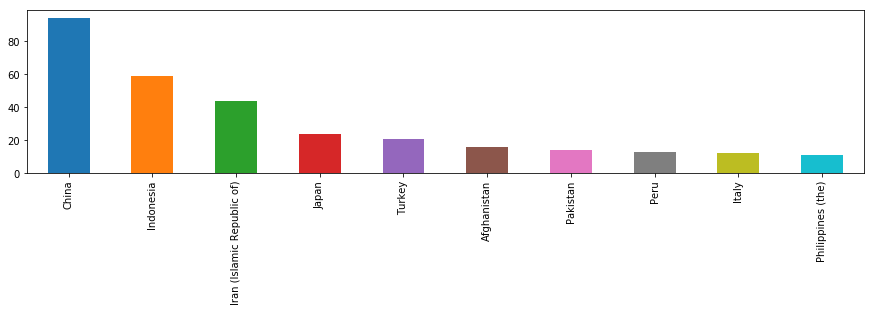

In [7]:
earthquake_data['Country'].value_counts().head(10).plot(kind='bar', figsize=(15,3))

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(

Text(0.5, 1.0, 'Distribution of Magnitude Values (Ritcher Scale)')

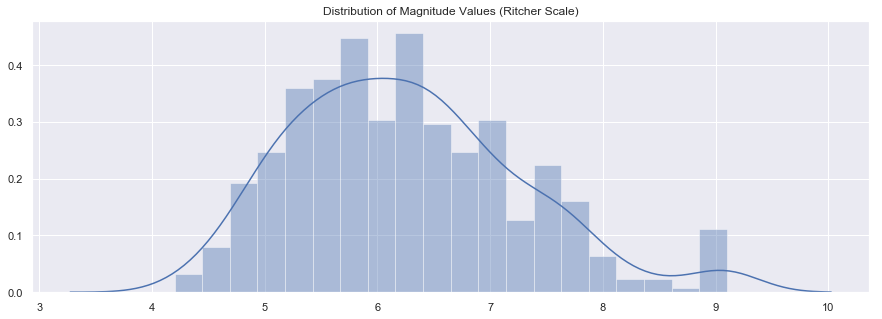

In [8]:
arr_magnitude = earthquake_data['Magnitude value'].values
sns.set(color_codes=True)
plt.figure(figsize=(15,5))
sns.distplot(arr_magnitude, bins=20)
plt.title("Distribution of Magnitude Values (Ritcher Scale)")

#### Correlation between Magnitude Value and Total Death?

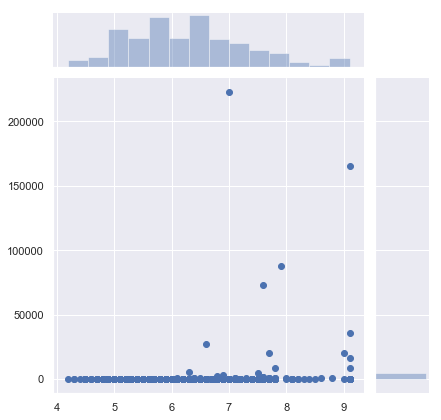

In [9]:
arr_death = earthquake_data['Total deaths'].values
sns.jointplot(arr_magnitude, arr_death)

## 3. Merging Datasets

In [10]:
## splitting earthquake details 'time' column into year and month
details_join = earthquake_details.copy()
details_join = details_join[['time', 'latitude', 'longitude', 'depth', 'mag','place','magType']]
details_join['year'] = details_join['time'].apply(lambda x: x.split('-')[0]).astype('int')
details_join['month'] = details_join['time'].apply(lambda x: x.split('-')[1]).astype('int')
details_join['day'] = details_join['time'].apply(lambda x: x.split('-')[2][:2]).astype('int')
details_join['latitude_round'] = round(details_join['latitude'])
details_join['longitude_round'] = round(details_join['longitude'])
details_join['mag_round'] = round(details_join['mag'])

def split_country(place):
    split_list = place.split(', ')
    list_len = len(split_list)
    if list_len > 1: return split_list[1]
    else: return split_list[0]
    
details_join['country'] = details_join['place'].astype(str).apply(lambda x: split_country(x))
remove_cardinal = ["southeastern ","northeastern ","southwestern ","northwestern ",
                   "western ","eastern ","southern ","northern ","near the coast of central "]
for loc in remove_cardinal:
    details_join['country'].replace(loc,"",regex=True,inplace=True)
details_join.head(3)

,time,latitude,longitude,depth,mag,place,magType,year,month,day,latitude_round,longitude_round,mag_round,country
0,2000-01-01T01:19:26.990Z,41.927,20.543,10.000,4.500,Albania,mb,2000,1,1,42.000,21.000,4.000,Albania
1,2000-01-01T04:30:10.370Z,-26.012,-68.803,105.000,4.500,"Atacama, Chile",mb,2000,1,1,-26.000,-69.000,4.000,Chile
2,2000-01-01T05:24:35.290Z,36.874,69.947,54.300,5.100,"Hindu Kush region, Afghanistan",mwc,2000,1,1,37.000,70.000,5.000,Afghanistan


In [11]:
## split natural disaster 'Start date' column into year, month, day
earthquake_feature_data = earthquake_data[['Start date','ISO','Country','Latitude','Longitude',
                                  'Magnitude value','Total deaths',"Total damage ('000 US$)"]].copy()
earthquake_feature_data['Month'] = earthquake_data['Start date'].apply(lambda x: x.split('/')[1]).astype('int')
earthquake_feature_data['Year'] = earthquake_data['Start date'].apply(lambda x: x.split('/')[2]).astype('int')
earthquake_feature_data['Day'] = earthquake_data['Start date'].apply(lambda x: x.split('/')[0]).astype('int')
earthquake_feature_data['Latitude_round'] = round(earthquake_data['Latitude'])
earthquake_feature_data['Longitude_round'] = round(earthquake_data['Longitude'])
earthquake_feature_data['Mag_round'] = round(earthquake_data['Magnitude value'])

## standardize country names
rename_country = [" \(the\)"," \(Islamic Republic of\)"," \(Province of China\)",
                  ", United Republic of"," \(the Democratic Republic of the\)", " Federation"]
earthquake_feature_data['Country'].replace("Russian Federation","Russia",regex=True,inplace=True)
for country in rename_country:
    earthquake_feature_data['Country'].replace(country,"",regex=True,inplace=True)

print(earthquake_feature_data.info())
print(earthquake_feature_data.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 14 columns):
Start date                 521 non-null object
ISO                        521 non-null object
Country                    521 non-null object
Latitude                   463 non-null float64
Longitude                  460 non-null float64
Magnitude value            511 non-null float64
Total deaths               521 non-null int64
Total damage ('000 US$)    521 non-null int64
Month                      521 non-null int64
Year                       521 non-null int64
Day                        521 non-null int64
Latitude_round             463 non-null float64
Longitude_round            460 non-null float64
Mag_round                  511 non-null float64
dtypes: float64(6), int64(5), object(3)
memory usage: 57.1+ KB
None
        Start date  ISO Country  Latitude  Longitude  Magnitude value  \
count          521  521     521   463.000    460.000          511.000   
unique         454   8

In [12]:
earthquake_feature_data.head(3)

,Start date,ISO,Country,Latitude,Longitude,Magnitude value,Total deaths,Total damage ('000 US$),Month,Year,Day,Latitude_round,Longitude_round,Mag_round
0,25/02/2001,AFG,Afghanistan,36.400,70.900,6.100,0,0,2,2001,25,36.000,71.000,6.000
1,01/06/2001,AFG,Afghanistan,35.169,69.389,5.000,4,0,6,2001,1,35.000,69.000,5.000
2,03/03/2002,AFG,Afghanistan,36.429,70.438,6.300,150,0,3,2002,3,36.000,70.000,6.000


In [13]:
details_join.head(3)

,time,latitude,longitude,depth,mag,place,magType,year,month,day,latitude_round,longitude_round,mag_round,country
0,2000-01-01T01:19:26.990Z,41.927,20.543,10.000,4.500,Albania,mb,2000,1,1,42.000,21.000,4.000,Albania
1,2000-01-01T04:30:10.370Z,-26.012,-68.803,105.000,4.500,"Atacama, Chile",mb,2000,1,1,-26.000,-69.000,4.000,Chile
2,2000-01-01T05:24:35.290Z,36.874,69.947,54.300,5.100,"Hindu Kush region, Afghanistan",mwc,2000,1,1,37.000,70.000,5.000,Afghanistan


In [14]:
unmerged_df = earthquake_feature_data.copy()
unmerged_df.reset_index(inplace=True)

### Merge Attempts

In [15]:
## Function to merge earthquake data based on input columns

def merge_data(earthquake,details,earth_col,details_col):
    details_dist = details.drop_duplicates(subset=details_col)
    df_merge = pd.merge(earthquake,details_dist,how='left',
                       left_on=earth_col,right_on=details_col)
    null = df_merge['mag'].isnull()
    print("Number of un-merged rows left: {}".format(null.sum()))
    null_index = df_merge[null]['index'].values
    #print("Un-merged index rows: {}".format(null_index))
    full_df=df_merge[~null]
    print("Merge dataframe shape: {}".format(full_df.shape))
    return full_df,null_index

In [16]:
## merge attempt 1: Exact Date, Exact Location, Exact Magnitude
merged_df1, null_index1 = merge_data(unmerged_df,details_join,
                                   ['Latitude','Longitude','Year','Month','Day','Magnitude value'],
                                   ['latitude','longitude','year','month','day','mag'])
unmerged_df1 = unmerged_df.iloc[null_index1,:]

Number of un-merged rows left: 251
Merge dataframe shape: (270, 29)


In [17]:
## merge attempt 2: Exact Date, Round Location, Exact Magnitude
merged_df2, null_index2 = merge_data(unmerged_df1,details_join,
                                   ['Latitude_round','Longitude_round','Year','Month','Day','Magnitude value'],
                                   ['latitude_round','longitude_round','year','month','day','mag'])
unmerged_df2 = unmerged_df.iloc[null_index2,:]

Number of un-merged rows left: 178
Merge dataframe shape: (73, 29)


In [18]:
## merge attempt 3: Exact Date, Exact Location, Round Magnitude
merged_df3, null_index3 = merge_data(unmerged_df2,details_join,
                                   ['Latitude','Longitude','Year','Month','Day','Mag_round'],
                                   ['latitude','longitude','year','month','day','mag_round'])
unmerged_df3 = unmerged_df.iloc[null_index3,:]

Number of un-merged rows left: 158
Merge dataframe shape: (20, 29)


In [19]:
## merge attempt 4: Exact Date, Round Location, Round Magnitude
merged_df4, null_index4 = merge_data(unmerged_df3,details_join,
                                   ['Latitude_round','Longitude_round','Year','Month','Day','Mag_round'],
                                   ['latitude_round','longitude_round','year','month','day','mag_round'])
unmerged_df4 = unmerged_df.iloc[null_index4,:]

Number of un-merged rows left: 127
Merge dataframe shape: (31, 29)


In [20]:
## merge attempt 5: Exact Date -1, Round Location, Round Magnitude
unmerged_df4_date_adj = unmerged_df4.copy()
unmerged_df4_date_adj['Day'] = unmerged_df4_date_adj['Day'].astype(int) - 1
merged_df5, null_index5 = merge_data(unmerged_df4_date_adj,details_join,
                                   ['Latitude_round','Longitude_round','Year','Month','Day','Mag_round'],
                                   ['latitude_round','longitude_round','year','month','day','mag_round'])
unmerged_df5 = unmerged_df.iloc[null_index5,:]

## merge attempt 6: Exact Date +1, Round Location, Round Magnitude
unmerged_df5_date_adj = unmerged_df5.copy()
unmerged_df5_date_adj['Day'] = unmerged_df5_date_adj['Day'].astype(int) + 1
merged_df6, null_index6 = merge_data(unmerged_df5_date_adj,details_join,
                                   ['Latitude_round','Longitude_round','Year','Month','Day','Mag_round'],
                                   ['latitude_round','longitude_round','year','month','day','mag_round'])
unmerged_df6 = unmerged_df.iloc[null_index6,:]

Number of un-merged rows left: 107
Merge dataframe shape: (20, 29)
Number of un-merged rows left: 105
Merge dataframe shape: (2, 29)


In [21]:
## merge attempt 7: Exact Date, Exact Location
merged_df7, null_index7 = merge_data(unmerged_df6,details_join,
                                   ['Latitude_round','Longitude_round','Year','Month','Day'],
                                   ['latitude_round','longitude_round','year','month','day'])
unmerged_df7 = unmerged_df.iloc[null_index7,:]

Number of un-merged rows left: 82
Merge dataframe shape: (23, 29)


In [22]:
## merge attempt 8: Exact Date, Exact Country, Rounded Magnitude
merged_df8, null_index8 = merge_data(unmerged_df7,details_join,
                                   ['Country','Year','Month','Day','Mag_round'],
                                   ['country','year','month','day','mag_round'])
unmerged_df8 = unmerged_df.iloc[null_index8,:]

Number of un-merged rows left: 42
Merge dataframe shape: (40, 29)


In [23]:
## merge attempt 9: Exact Date -1, Exact Country
unmerged_df8_date_adj = unmerged_df8.copy()
unmerged_df8_date_adj['Day'] = unmerged_df8_date_adj['Day'].astype(int) - 1
merged_df9, null_index9 = merge_data(unmerged_df8_date_adj,details_join,
                                   ['Country','Year','Month','Day'],
                                   ['country','year','month','day'])
unmerged_df9 = unmerged_df.iloc[null_index9,:]

## merge attempt 10: Exact Date +1, Exact Country
unmerged_df9_date_adj = unmerged_df9.copy()
unmerged_df9_date_adj['Day'] = unmerged_df9_date_adj['Day'].astype(int) + 1
merged_df10, null_index10 = merge_data(unmerged_df9_date_adj,details_join,
                                   ['Country','Year','Month','Day'],
                                   ['country','year','month','day'])
unmerged_df10 = unmerged_df.iloc[null_index10,:]

Number of un-merged rows left: 26
Merge dataframe shape: (16, 29)
Number of un-merged rows left: 21
Merge dataframe shape: (5, 29)


In [24]:
drop_rows = [28,476,343,352,318,307,161,96,136,151,165,185,190,103,298,348,362,506]
unmerged_df10 = unmerged_df9[~unmerged_df9['index'].isin(drop_rows)]
print(unmerged_df10.shape)
unmerged_df10

(8, 15)


,index,Start date,ISO,Country,Latitude,Longitude,Magnitude value,Total deaths,Total damage ('000 US$),Month,Year,Day,Latitude_round,Longitude_round,Mag_round
81,81,27/10/2006,CHN,China,nan,nan,4.700,0,0,10,2006,27,nan,nan,5.000
188,188,15/09/2007,HND,Honduras,14.850,88.060,5.500,0,0,9,2007,15,15.000,88.000,6.000
189,189,28/05/2009,HND,Honduras,16.731,86.220,7.100,7,100000,5,2009,28,17.000,86.000,7.000
253,253,01/08/2016,IDN,Indonesia,-8.218,117.816,5.900,0,0,8,2016,1,-8.000,118.000,6.000
398,398,25/12/2015,PAK,Pakistan,nan,nan,6.300,3,0,12,2015,25,nan,nan,6.000
419,419,27/09/2014,PER,Peru,nan,nan,5.100,8,0,9,2014,27,nan,nan,5.000
420,420,14/08/2016,PER,Peru,-15.640,-71.680,5.300,4,0,8,2016,14,-16.000,-72.000,5.000
467,467,01/04/2004,TJK,Tajikistan,nan,nan,nan,0,0,4,2004,1,nan,nan,nan


In [25]:
details_manual_merge = details_join.copy()
details_manual_merge.reset_index(inplace=True)

In [26]:
manual_merge = [(467,21165),(398,107067),(81,39366),(188,46086),(189,57039),(253,111048),(419,97892),(420,111326)]
def join_row(index1,index2):
    row1 = unmerged_df[unmerged_df['index']==index1]
    row2 = details_join[details_manual_merge['index']==index2]
    row1.reset_index(drop=True, inplace=True)
    row2.reset_index(drop=True, inplace=True)
    row = pd.concat([row1,row2],axis=1)
    return row
manual_row_list = [join_row(pair[0],pair[1]) for pair in manual_merge]
manual_merge_df = pd.concat(manual_row_list,axis=0,ignore_index=True)

In [27]:
merged_df = pd.concat([merged_df1,merged_df2,merged_df3,merged_df4,merged_df5,merged_df6,merged_df7,merged_df8,merged_df9])
print(merged_df.shape)
print(merged_df.columns)

(495, 29)
Index(['index', 'Start date', 'ISO', 'Country', 'Latitude', 'Longitude',
       'Magnitude value', 'Total deaths', 'Total damage ('000 US$)', 'Month',
       'Year', 'Day', 'Latitude_round', 'Longitude_round', 'Mag_round', 'time',
       'latitude', 'longitude', 'depth', 'mag', 'place', 'magType', 'year',
       'month', 'day', 'latitude_round', 'longitude_round', 'mag_round',
       'country'],
      dtype='object')


## 4. Finding Outliers

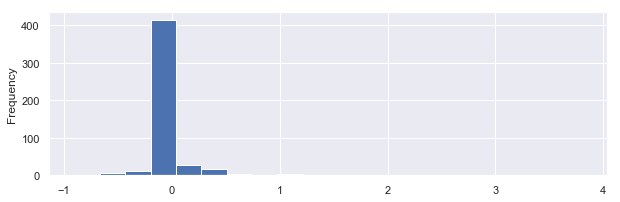

In [28]:
merged_df['diff_mag'] = merged_df['Magnitude value'] - merged_df['mag']
merged_df['diff_mag'].plot(kind='hist',bins=20,figsize=(10,3))

In [29]:
outliers_drop_rows = merged_df[abs(merged_df['diff_mag'])>0.5]['index'].values
other_drop_rows = [385,424]
merged_df = merged_df[~merged_df['index'].isin(outliers_drop_rows)]
merged_df = merged_df[~merged_df['index'].isin(other_drop_rows)]
print(merged_df.shape)

(478, 30)


In [30]:
outliers_manual_merge = [(43,61517),(257,124870),
                         (248,84894),(342,125794),(346,120216),
                         (166,123411),(380,68817),(385,93899),
                         (424,58657)
                        ]
outliers_row_list = [join_row(pair[0],pair[1]) for pair in outliers_manual_merge]
outliers_df = pd.concat(outliers_row_list,axis=0,ignore_index=True)
outliers_df

,index,Start date,ISO,Country,Latitude,Longitude,Magnitude value,Total deaths,Total damage ('000 US$),Month,...,mag,place,magType,year,month,day,latitude_round,longitude_round,mag_round,country
0,43,27/02/2010,CHL,Chile,-39.122,-72.898,8.800,562,30000000,2,...,8.800,"offshore Bio-Bio, Chile",mww,2010,2,27,-36.000,-73.000,9.000,Chile
1,257,29/07/2018,IDN,Indonesia,-8.274,116.491,6.400,14,29000,7,...,6.400,"5km WNW of Obelobel, Indonesia",mww,2018,7,28,-8.000,117.000,6.000,Indonesia
2,248,22/01/2013,IDN,Indonesia,nan,nan,5.900,1,0,1,...,6.100,"47km SSW of Sigli, Indonesia",mww,2013,1,21,5.000,96.000,6.000,Indonesia
3,342,06/09/2018,JPN,Japan,nan,nan,6.600,44,1250000,9,...,6.600,"27km ENE of Tomakomai, Japan",mww,2018,9,5,43.000,142.000,7.000,Japan
4,346,15/11/2017,KOR,Korea (the Republic of),36.065,129.270,5.400,0,0,11,...,5.500,"7km WSW of Heung-hai, South Korea",mww,2017,11,15,36.000,129.000,6.000,South Korea
5,166,06/05/2018,SLV,El Salvador,13.095,-88.099,5.600,0,0,5,...,5.400,"10km S of Intipuca, El Salvador",mww,2018,5,6,13.000,-88.000,5.000,El Salvador
6,380,22/02/2011,NZL,New Zealand,-43.583,172.680,6.100,181,15000000,2,...,6.100,South Island of New Zealand,mww,2011,2,21,-44.000,173.000,6.000,South Island of New Zealand
7,385,11/04/2014,NIC,Nicaragua,11.642,-85.880,6.100,2,3000,4,...,6.600,"15km N of Belen, Nicaragua",mww,2014,4,11,12.000,-86.000,7.000,Nicaragua
8,424,18/09/2009,PHL,Philippines,6.513,24.710,5.700,0,90,9,...,5.700,"Mindanao, Philippines",mwc,2009,9,18,7.000,125.000,6.000,Philippines


In [31]:
final_merged_df = pd.concat([merged_df,outliers_df,manual_merge_df],axis=0,ignore_index=True,sort=False)
final_merged_df['Magnitude value'][final_merged_df['Magnitude value'].isnull()] = final_merged_df['mag']
final_merged_df['Latitude'][final_merged_df['Latitude'].isnull()] = final_merged_df['latitude']
final_merged_df['Longitude'][final_merged_df['Longitude'].isnull()] = final_merged_df['longitude']
final_merged_df['diff_mag'] = final_merged_df['Magnitude value'] - final_merged_df['mag']
final_merged_df.head(3)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,index,Start date,ISO,Country,Latitude,Longitude,Magnitude value,Total deaths,Total damage ('000 US$),Month,...,place,magType,year,month,day,latitude_round,longitude_round,mag_round,country,diff_mag
0,1,01/06/2001,AFG,Afghanistan,35.169,69.389,5.000,4,0,6,...,"Hindu Kush region, Afghanistan",mwc,2001.000,6.000,1.000,35.000,69.000,5.000,Afghanistan,0.000
1,2,03/03/2002,AFG,Afghanistan,36.429,70.438,6.300,150,0,3,...,"Hindu Kush region, Afghanistan",mb,2002.000,3.000,3.000,36.000,70.000,6.000,Afghanistan,0.000
2,6,18/07/2004,AFG,Afghanistan,33.426,69.524,5.200,2,0,7,...,central Afghanistan,mwc,2004.000,7.000,18.000,33.000,70.000,5.000,central Afghanistan,0.000


In [32]:
def update_values(index, column, value):
    row_index = final_merged_df[final_merged_df['index']==index].index
    final_merged_df.at[row_index,column] = value

update_list = [[155,'Longitude',-85.310],
               [365,'Longitude',-100.970],
               [188,'Longitude',-88.060],
               [43,'Latitude',-36.122],
               [480,'Latitude',-1.036],
               [189,'Longitude',-86.220],
               [453,'Latitude',-26.913],
               [260,'Latitude',-0.000],
               [38, 'Latitude',42.645],
               [192,'Latitude',63.966],
               [294,'Latitude',36.288],
               [294,'Longitude',58.835],
               [424,'Longitude',124.715],
               [416,'Longitude',-75.966],
               [188,'Longitude',-87.12],
               [422,'Longitude',-74.710]]

for update in update_list:
    index = update[0]
    column = update[1]
    value = update[2]
    update_values(index,column,value)

In [33]:
final_merged_df['diff_lat'] = final_merged_df['Latitude'] - final_merged_df['latitude']
final_merged_df['diff_long'] = final_merged_df['Longitude'] - final_merged_df['longitude']

,index,Start date,ISO,Country,Latitude,Longitude,Magnitude value,Total deaths,Total damage ('000 US$),Month,...,year,month,day,latitude_round,longitude_round,mag_round,country,diff_mag,diff_lat,diff_long


In [34]:
final_merged_df.to_csv("earthquake_data.csv")